In [68]:
import cv2
import os

def extract_frames(input_video_path, output_frames_dir):
    # Check if input video file exists
    if not os.path.isfile(input_video_path):
        print("Error: Input video file does not exist.")
        return
    
    # Create the output directory if it doesn't exist
    os.makedirs(output_frames_dir, exist_ok=True)
    
    # Open the input video file
    input_video = cv2.VideoCapture(input_video_path)
    if not input_video.isOpened():
        print("Error: Unable to open input video.")
        return
    
    # Loop through the video frames
    frame_count = 0
    while True:
        # Read a frame from the input video
        ret, frame = input_video.read()
        
        # Check if frame is successfully read
        if not ret:
            break
        
        # Extract every th frame
        if frame_count % 5 == 0:
            # Save the frame as an image file
            frame_filename = os.path.join(output_frames_dir, f"frame_{frame_count:04d}.jpg")
            cv2.imwrite(frame_filename, frame)
        
        # Increment frame count
        frame_count += 1

    # Release the video object
    input_video.release()
    print("Frames extraction completed.")

# Path to the input video file
input_video_path = "3CYL_Flow.mp4"
# Directory to save the extracted frames
output_frames_dir = "extracted_frames11"

# Call the function to extract frames
extract_frames(input_video_path, output_frames_dir)


Frames extraction completed.


In [69]:
import numpy as np
import os
import cv2

def read_and_preprocess_images(directory, target_size=(100, 100)):
    images = []
    for filename in sorted(os.listdir(directory)):
        if filename.endswith(".jpg"):
            filepath = os.path.join(directory, filename)
            image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
            resized_image = cv2.resize(image, target_size)
            normalized_image = resized_image.astype(np.float32) / 255.0  # Normalize pixel values
            images.append(normalized_image)
    return images

def perform_svd(images):
    # Convert images to a 2D array
    num_images = len(images)
    image_shape = images[0].shape
    data_matrix = np.zeros((num_images, image_shape[0] * image_shape[1]))
    for i, image in enumerate(images):
        data_matrix[i, :] = image.flatten()
    
    # Perform SVD
    u, s, vt = np.linalg.svd(data_matrix, full_matrices=False)
    
    return u, s, vt

# Directory containing the images
input_directory = "extracted_frames11"
# Read and preprocess images
images = read_and_preprocess_images(input_directory)
# Perform SVD
u, s, vt = perform_svd(images)

# Print the shapes of U, Sigma, and V^T
print("Shape of U:", u.shape)
print(u)
print("Shape of Sigma:", s.shape)
print(s)
print("Shape of V^T:", vt.shape)
print(vt)


Shape of U: (151, 151)
[[-0.08431599  0.01712536 -0.00293273 ... -0.01281467 -0.02085641
   0.00945636]
 [-0.08411362  0.00514605 -0.01357893 ...  0.01728123  0.03416169
  -0.02054565]
 [-0.08378671 -0.03171191 -0.03342272 ... -0.00379645 -0.01204133
   0.00376291]
 ...
 [-0.08149398 -0.12487154  0.01018432 ... -0.1267535   0.09289126
  -0.25240413]
 [-0.08145116  0.1093669  -0.05243734 ...  0.27197123 -0.23547194
  -0.01130621]
 [-0.08124853 -0.09217914  0.11089991 ...  0.11164464  0.3014794
  -0.12437113]]
Shape of Sigma: (151,)
[1.03761172e+03 1.14073517e+01 1.05683878e+01 8.66069871e+00
 8.23844178e+00 7.80885226e+00 7.57035061e+00 7.29270971e+00
 7.25224596e+00 6.92934577e+00 6.59550673e+00 6.13874579e+00
 5.95690630e+00 5.76627098e+00 5.52102441e+00 5.28877779e+00
 5.15763345e+00 4.93589300e+00 4.62219402e+00 4.47147717e+00
 4.42654903e+00 4.36504011e+00 4.15329008e+00 3.88987281e+00
 3.80491189e+00 3.68260987e+00 3.62569819e+00 3.53006914e+00
 3.36661696e+00 3.33061131e+00 3.245

In [70]:


def reconstruct_top_modes(u, s, vt, num_modes, target_size=(100, 100)):
    # Select the top modes
    top_u = u[:, :num_modes]
    top_s = np.diag(s[:num_modes])
    top_vt = vt[:num_modes, :]
    
    # Reconstruct images
    reconstructed_images = np.dot(np.dot(top_u, top_s), top_vt)
    
    # Reshape and denormalize images
    reconstructed_images = (reconstructed_images * 255.0).astype(np.uint8)
    reconstructed_images = reconstructed_images.reshape((-1, *target_size))
    
    return reconstructed_images

# Directory containing the images
input_directory = "extracted_frames11"
# Directory to save reconstructed images
output_directory = "reconstructed_images11"
# Read and preprocess images
images = read_and_preprocess_images(input_directory)
# Perform SVD
u, s, vt = perform_svd(images)
# Number of modes to reconstruct
num_modes = 10
# Reconstruct top modes
reconstructed_images = reconstruct_top_modes(u, s, vt, num_modes)

# Create the output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Save reconstructed images to the output directory
for i, image in enumerate(reconstructed_images):
    cv2.imwrite(os.path.join(output_directory, f"reconstructed_mode_{i}.jpg"), image)


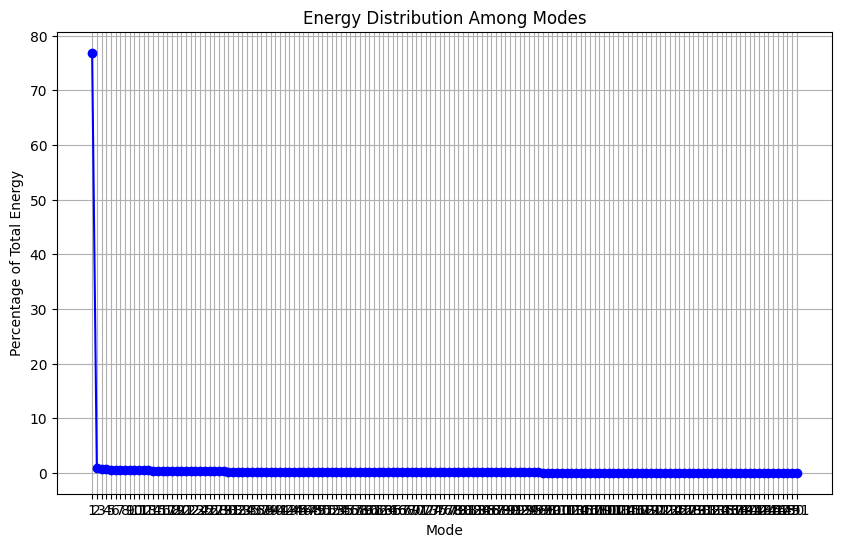

Top 10 Energy States:
Mode 1: 76.89% of total energy
Mode 2: 0.85% of total energy
Mode 3: 0.78% of total energy
Mode 4: 0.64% of total energy
Mode 5: 0.61% of total energy
Mode 6: 0.58% of total energy
Mode 7: 0.56% of total energy
Mode 8: 0.54% of total energy
Mode 9: 0.54% of total energy
Mode 10: 0.51% of total energy


In [71]:
import numpy as np
import matplotlib.pyplot as plt

def plot_energy_distribution(s, num_modes=10):
    total_energy = np.sum(s)
    energy_distribution = s / total_energy * 100  # Convert to percentage
    cumulative_energy = np.cumsum(energy_distribution)
    
    # Plot energy distribution
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(s) + 1), energy_distribution, marker='o', linestyle='-', color='b')
    plt.title('Energy Distribution Among Modes')
    plt.xlabel('Mode')
    plt.ylabel('Percentage of Total Energy')
    plt.xticks(range(1, len(s) + 1))
    plt.grid(True)
    plt.show()
    
    # Report top 10 energy states
    print("Top 10 Energy States:")
    for i in range(num_modes):
        print(f"Mode {i+1}: {energy_distribution[i]:.2f}% of total energy")
        

# Calculate energy distribution and plot
plot_energy_distribution(s, num_modes=10)


In [74]:
import numpy as np
import os
import cv2

# Function to add speckle noise to an image
def add_speckle_noise(image, magnitude):
    noisy_image = np.copy(image)
    noise = magnitude / 100 * np.random.randn(*image.shape)
    noisy_image = noisy_image + noisy_image * noise
    np.clip(noisy_image, 0, 255, out=noisy_image)
    noisy_image = noisy_image.astype(np.uint8)
    return noisy_image

# Function to add Poisson noise to an image
def add_poisson_noise(image, magnitude):
    noisy_image = np.copy(image)
    vals = len(np.unique(image))
    vals = 2 ** np.ceil(np.log2(vals))
    noisy_image = np.random.poisson(image * (magnitude / 100) * vals) / float(vals)
    noisy_image = noisy_image.astype(np.uint8)
    return noisy_image

# Directory containing the original frames
original_directory = "extracted_frames11"

# Directory to save noisy frames
noisy_directory = "noisy_frames"

# Magnitudes of noise (20%, 40%, 60%, 80% of maximum pixel value)
magnitudes = [20, 40, 60, 80]

# Create the directory to save noisy frames if it doesn't exist
os.makedirs(noisy_directory, exist_ok=True)

# Iterate over original frames
for filename in os.listdir(original_directory):
    if filename.endswith(".jpg"):
        filepath = os.path.join(original_directory, filename)
        image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

        # Create subdirectories for speckle and Poisson noise
        speckle_subdirectory = os.path.join(noisy_directory, "speckle")
        poisson_subdirectory = os.path.join(noisy_directory, "poisson")
        os.makedirs(speckle_subdirectory, exist_ok=True)
        os.makedirs(poisson_subdirectory, exist_ok=True)
        
        # Add speckle noise
        for magnitude in magnitudes:
            noisy_image = add_speckle_noise(image, magnitude)
            noisy_filename = f"{filename[:-4]}_speckle_{magnitude}.jpg"
            noisy_filepath = os.path.join(speckle_subdirectory, noisy_filename)
            cv2.imwrite(noisy_filepath, noisy_image)
        
        # Add Poisson noise
        for magnitude in magnitudes:
            noisy_image = add_poisson_noise(image, magnitude)
            noisy_filename = f"{filename[:-4]}_poisson_{magnitude}.jpg"
            noisy_filepath = os.path.join(poisson_subdirectory, noisy_filename)
            cv2.imwrite(noisy_filepath, noisy_image)


In [86]:
import matplotlib.pyplot as plt

# Function to read and preprocess images
def read_and_preprocess_images(directory, target_size=(64, 64)):
    images = []
    for filename in sorted(os.listdir(directory)):
        if filename.endswith(".jpg"):
            filepath = os.path.join(directory, filename)
            image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
            resized_image = cv2.resize(image, target_size)
            normalized_image = resized_image.astype(np.float32) / 255.0  # Normalize pixel values
            images.append(normalized_image)
    return images

# Function to perform SVD and return energies
def perform_svd(images):
    # Convert images to a 2D array
    num_images = len(images)
    image_shape = images[0].shape
    data_matrix = np.zeros((num_images, image_shape[0] * image_shape[1]))
    for i, image in enumerate(images):
        data_matrix[i, :] = image.flatten()
    
    # Perform SVD
    u, s, vt = np.linalg.svd(data_matrix, full_matrices=False)
    
    # Calculate energies
    energies = s**2 / np.sum(s**2)
    
    return energies

# Directories containing the images
speckle_directory = os.path.join(noisy_directory, "speckle")
poisson_directory = os.path.join(noisy_directory, "poisson")

# Read and preprocess images
speckle_images = read_and_preprocess_images(speckle_directory)
poisson_images = read_and_preprocess_images(poisson_directory)

# Perform SVD and get energies
speckle_energies = perform_svd(speckle_images)
poisson_energies = perform_svd(poisson_images)

# Print the top 10 energy modes
print("Top 10 energy modes for speckle noise:")
for i in range(10):
    print(f"Mode {i+1}: {speckle_energies[i]*100:.2f}% of total energy")

print("\nTop 10 energy modes for Poisson noise:")
for i in range(10):
    print(f"Mode {i+1}: {poisson_energies[i]*100:.2f}% of total energy")


Top 10 energy modes for speckle noise:
Mode 1: 94.09% of total energy
Mode 2: 0.03% of total energy
Mode 3: 0.03% of total energy
Mode 4: 0.03% of total energy
Mode 5: 0.02% of total energy
Mode 6: 0.02% of total energy
Mode 7: 0.02% of total energy
Mode 8: 0.02% of total energy
Mode 9: 0.02% of total energy
Mode 10: 0.02% of total energy

Top 10 energy modes for Poisson noise:
Mode 1: 99.87% of total energy
Mode 2: 0.01% of total energy
Mode 3: 0.01% of total energy
Mode 4: 0.01% of total energy
Mode 5: 0.01% of total energy
Mode 6: 0.01% of total energy
Mode 7: 0.01% of total energy
Mode 8: 0.01% of total energy
Mode 9: 0.00% of total energy
Mode 10: 0.00% of total energy


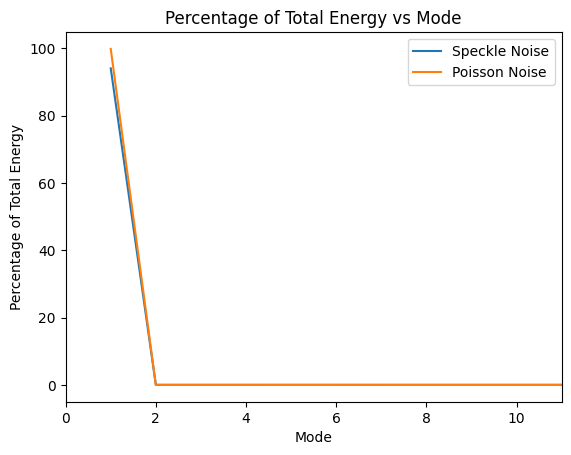

In [95]:
# Calculate the maximum mode number
max_mode = max(len(speckle_energies_percent), len(poisson_energies_percent))

# Create a new figure
plt.figure()

# Plot the percentage of energy for speckle noise
plt.plot(np.arange(1, len(speckle_energies_percent) + 1), speckle_energies_percent, label='Speckle Noise')

# Plot the percentage of energy for Poisson noise
plt.plot(np.arange(1, len(poisson_energies_percent) + 1), poisson_energies_percent, label='Poisson Noise')

# Set x-axis limit to start from 1 and end at the maximum mode number
plt.xlim(0,11)

# Add labels and title
plt.xlabel('Mode')
plt.ylabel('Percentage of Total Energy')
plt.title('Percentage of Total Energy vs Mode')

# Add a legend
plt.legend()

# Display the plot
plt.show()


In [111]:
import cv2
import numpy as np
import os
import concurrent.futures

def denoise_image(filepath, output_directory, d=15, sigmaColor=75, sigmaSpace=75):
    # Read the image
    image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    
    # Denoise the image using Bilateral Filter
    denoised_image = cv2.bilateralFilter(image, d, sigmaColor, sigmaSpace)
    
    # Save the denoised image to the output directory
    filename = os.path.basename(filepath)
    output_filepath = os.path.join(output_directory, filename)
    cv2.imwrite(output_filepath, denoised_image)

def denoise_images_in_directory(input_directory, output_directory):
    # Create a list of filepaths to the images in the input directory
    filepaths = [os.path.join(input_directory, filename) for filename in sorted(os.listdir(input_directory)) if filename.endswith(".jpg")]
    
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    
    # Use a ThreadPoolExecutor to denoise the images in parallel
    with concurrent.futures.ThreadPoolExecutor() as executor:
        for filepath in filepaths:
            executor.submit(denoise_image, filepath, output_directory)

# Specify your input and output directories
input_directory = "noisy_frames\poisson"
output_directory = "denoisepoisson"

# Denoise the images in the input directory and save them to the output directory
denoise_images_in_directory(input_directory, output_directory)


In [112]:
import cv2
import numpy as np
import os
import concurrent.futures

def denoise_image(filepath, output_directory, d=15, sigmaColor=75, sigmaSpace=75):
    # Read the image
    image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    
    # Denoise the image using Bilateral Filter
    denoised_image = cv2.bilateralFilter(image, d, sigmaColor, sigmaSpace)
    
    # Save the denoised image to the output directory
    filename = os.path.basename(filepath)
    output_filepath = os.path.join(output_directory, filename)
    cv2.imwrite(output_filepath, denoised_image)

def denoise_images_in_directory(input_directory, output_directory):
    # Create a list of filepaths to the images in the input directory
    filepaths = [os.path.join(input_directory, filename) for filename in sorted(os.listdir(input_directory)) if filename.endswith(".jpg")]
    
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    
    # Use a ThreadPoolExecutor to denoise the images in parallel
    with concurrent.futures.ThreadPoolExecutor() as executor:
        for filepath in filepaths:
            executor.submit(denoise_image, filepath, output_directory)

# Specify your input and output directories
input_directory = "noisy_frames\speckle"
output_directory = "denoisespeckle"

# Denoise the images in the input directory and save them to the output directory
denoise_images_in_directory(input_directory, output_directory)
